# Homework 7: scikit-image

Due Tuesday Apr 10, 6pm

## Counting objects

In class, we saw how to count the number of objects in a microscopy image.  Here, we will repeat that exercise, but make use of some of the algorithms in `scikit-image` to segment the image, and then to determine properties of the resulting objects.

As input, use the image `skimage.data.coins`.  Segment the image, and then calculate the area and eccentricity of each coin.

There are various ways to do this.  One would be:

1. Equalize the input image (see `skimage.exposure`)
2. Threshold the image (`skimage.filters.otsu`)
3. Remove objects touching the boundary (`skimage.segmentation.clear_border`)
4. Apply morphological closing (`skimage.morphology.closing`)
5. Remove small objects (`skimage.measure.regionprops`).
   Visualize the results if you want with `skimage.color.label2rgb`.
7. Calculate the area and eccentricity of each coin, and display the
   original image with this information on it (`matplotlib.pyplot.text` or `matplotlib.pyplot.annotate`)

In [1]:
#load the image
from skimage import data, io, exposure, filters
import matplotlib.pyplot as plt
from skimage import img_as_float

coins = img_as_float(data.coins())
io.imshow(coins)
plt.show()

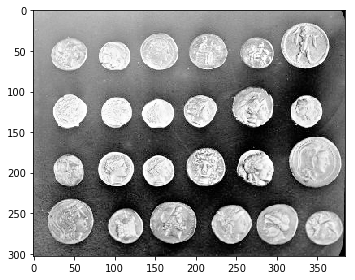

In [2]:
#adjust the image to have more sensative contrast in the range of highest pixel intensity density
eq_coins = exposure.equalize_hist(coins)
io.imshow(eq_coins)
plt.show()

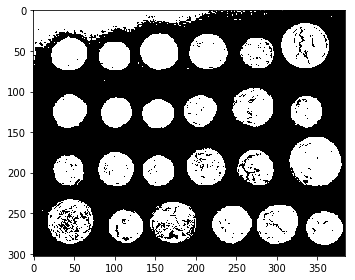

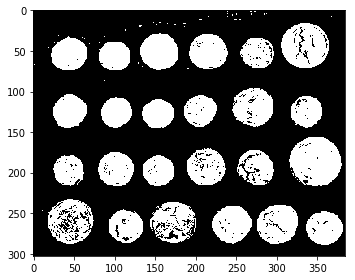

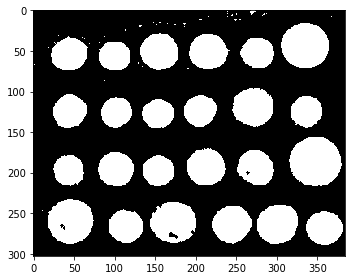

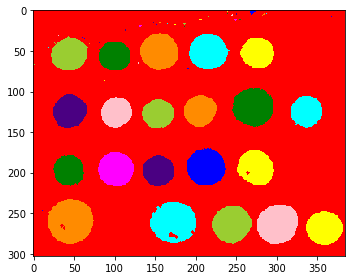

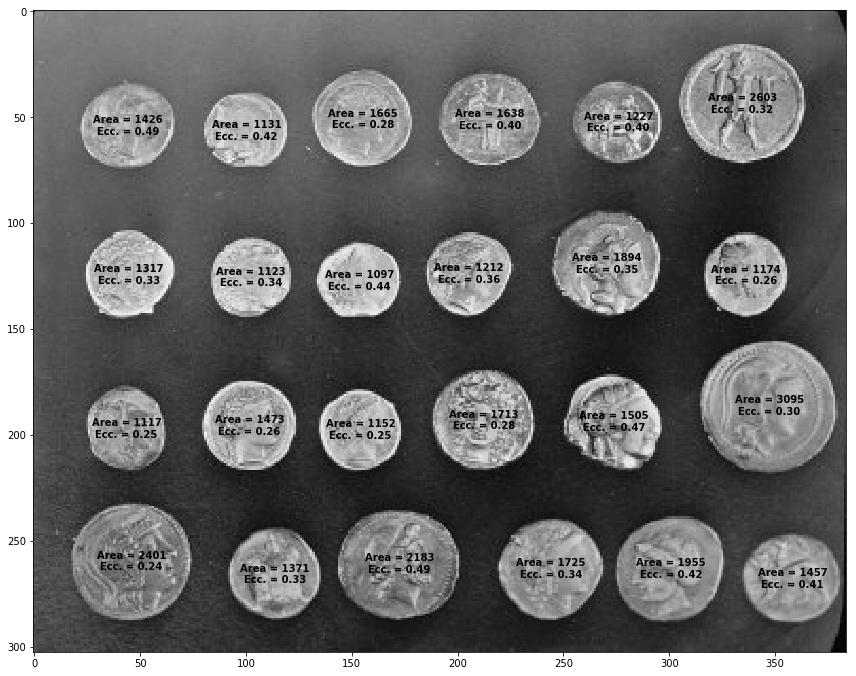

In [22]:
from skimage.morphology import closing, disk
from skimage.segmentation import clear_border
from skimage.measure import regionprops, label
from skimage import color

threshold = filters.threshold_otsu(eq_coins)  #find the threshold for the image
th_coins = eq_coins>threshold * 1.3 #adjust it slightly so all coins are found
io.imshow(th_coins)
plt.show()

cleared_coins = clear_border(th_coins,buffer_size=0) #remove obejcts that are not in the center (like the coins)
io.imshow(cleared_coins)
plt.show()

closed_coins = closing(cleared_coins,disk(2))#fill in the gaps within the coins
io.imshow(closed_coins)
plt.show()

labeled = label(closed_coins)  #asign labels to the whole image
io.imshow(color.label2rgb(labeled))
plt.show()

plt.figure(figsize=(12,12))
io.imshow(coins)
regions = regionprops(labeled)
for region in regions:  #loop over all labeled objects
    if region.area >100:  #ignore small objects
        area = region.area
        ec = region.eccentricity  #put relivent data over center of large objects (the coins)
        x,y = region.centroid
        plt.text(y,x,"Area = "+str(area)+"\nEcc. = "+str(ec)[:4],weight='bold',horizontalalignment='center',verticalalignment='center')

## Panorama stitching

One of the scikit-image tutorials shows [how to do panorama stitching](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb).

Take 3 or 4 overlapping photos of your own, and use the procedure described to stitch your own panorama.

Since I will be very closely following the tutorial above, I've added in descriptions of the process I am undertaking. I am not trying to copy the descriptions listed in the tutorial but rather restate the purpose of each chunk of code to convey my understand of 

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

def compare(*images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    f.tight_layout()


First we load in 4 images of seals I took at Pier 39 in SF

In [27]:
import skimage.io as io  

pano_imgs = io.ImageCollection('images/seal*')

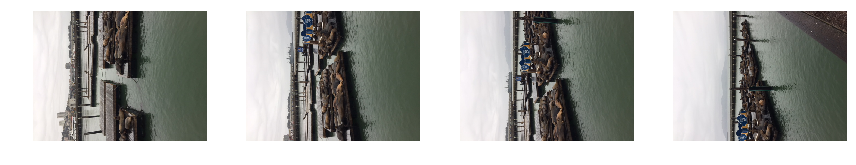

In [28]:
compare(*pano_imgs, figsize=(12, 10))

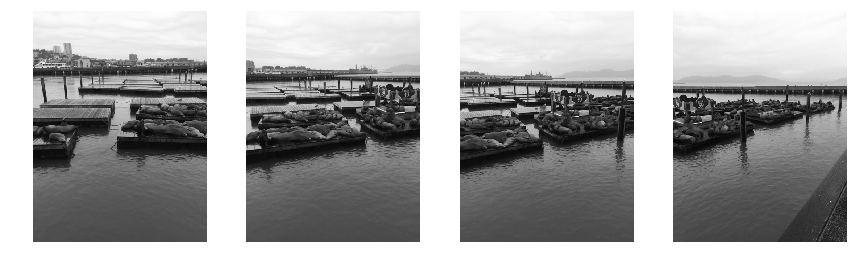

In [29]:
from skimage.color import rgb2gray

pano0, pano1, pano2, pano3 = [rgb2gray(ndimage.rotate(im,-90)) for im in pano_imgs]


# View the results
compare(pano0, pano1, pano2, pano3, figsize=(12, 10))

Now we detect key features within each image and match them across adjacent images

In [43]:
from skimage.feature import ORB

# Initialize ORB
# 800 keypoints is large enough for robust results, 
# but low enough to run within a few seconds. 
orb = ORB(n_keypoints=800, fast_threshold=0.05)

# Detect keypoints in pano0
orb.detect_and_extract(pano0)
keypoints0 = orb.keypoints
descriptors0 = orb.descriptors

# Detect keypoints in pano1
orb.detect_and_extract(pano1)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

# Detect keypoints in pano2
orb.detect_and_extract(pano2)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

# Detect keypoints in pano3
orb.detect_and_extract(pano3)
keypoints3 = orb.keypoints
descriptors3 = orb.descriptors


In [44]:

from skimage.feature import match_descriptors

# Match descriptors between left/right images and the center
matches01 = match_descriptors(descriptors0, descriptors1, cross_check=True)
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
matches23 = match_descriptors(descriptors2, descriptors3, cross_check=True)

Lets see which matches we have made

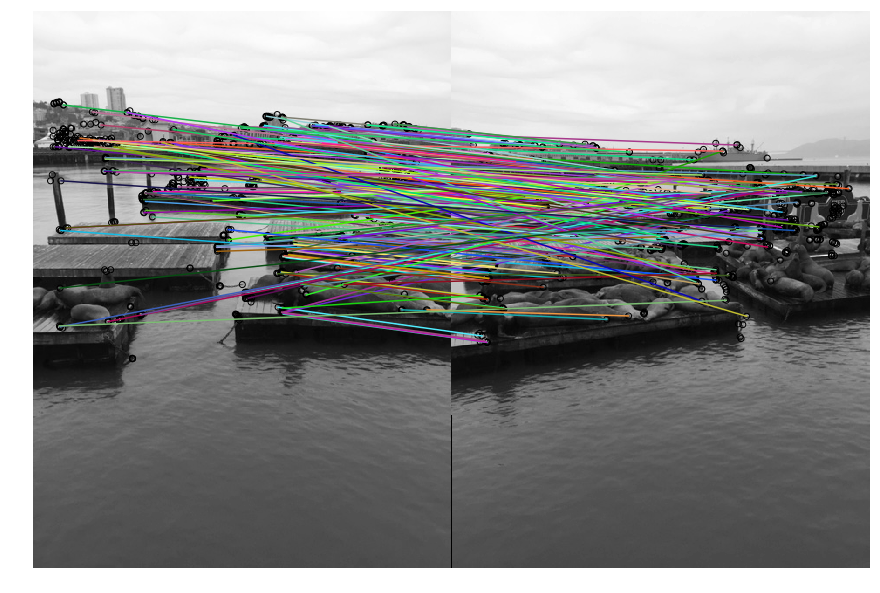

In [45]:
from skimage.feature import plot_matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, pano0, pano1, keypoints0, keypoints1, matches01)
ax.axis('off');

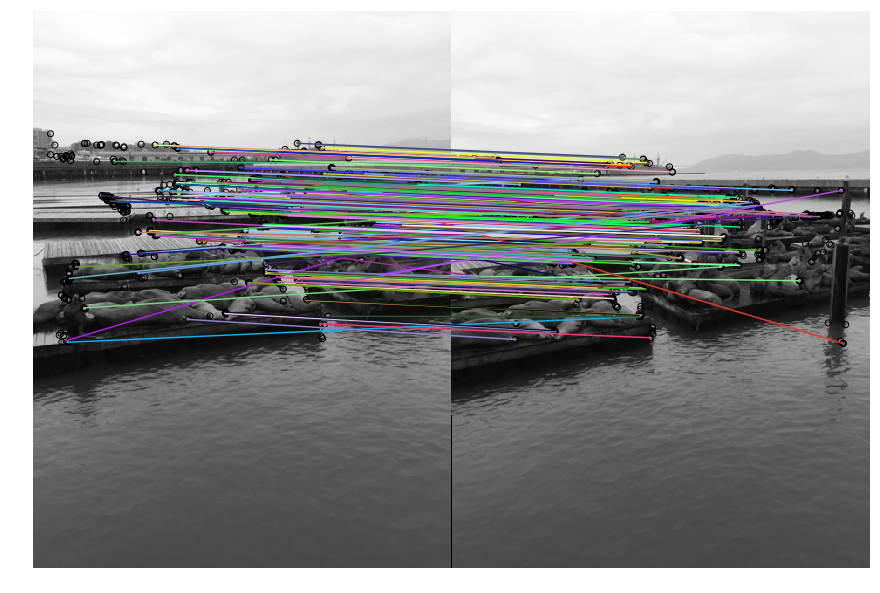

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano2 -> pano1
plot_matches(ax, pano1, pano2, keypoints1, keypoints2, matches12)
ax.axis('off');

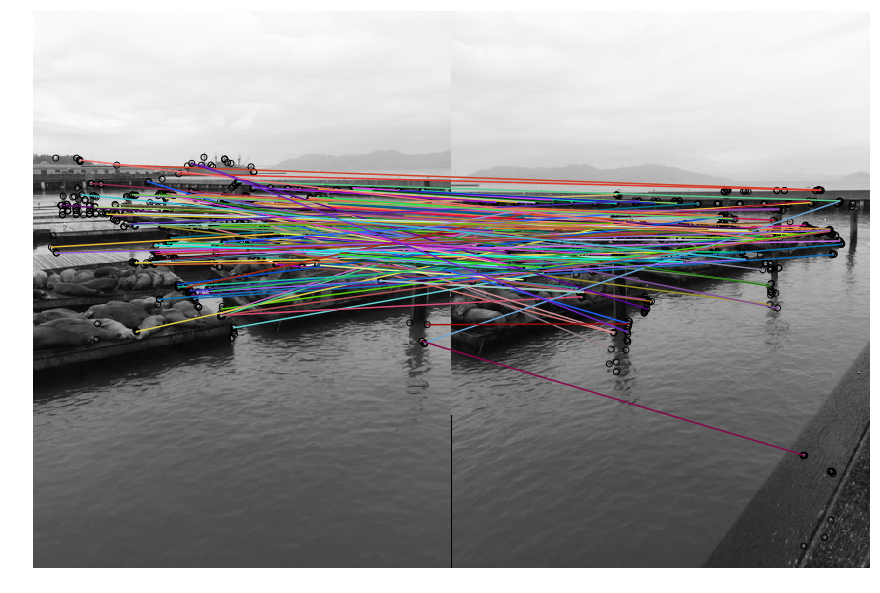

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano3 -> pano2
plot_matches(ax, pano2, pano3, keypoints2, keypoints3, matches23)
ax.axis('off');

We use these matches to find a map between adjacent images, se we need to find which of these matches are accurate and give the most consistent map. For this we use the RANSAC method which gives us the map that most accurately maps the most matches onto one another.

In [48]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

# Select keypoints from 
#   * source (image to be registered): pano0
#   * target (reference image): pano1, our middle frame registration target
src = keypoints0[matches01[:, 0]][:, ::-1]
dst = keypoints1[matches01[:, 1]][:, ::-1]

model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

# Select keypoints from 
#   * source (image to be registered): pano2
#   * target (reference image): pano1, our middle frame registration target
src = keypoints2[matches12[:, 1]][:, ::-1]
dst = keypoints1[matches12[:, 0]][:, ::-1]

model_robust12, inliers12 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)

# Select keypoints from 
#   * source (image to be registered): pano3
#   * target (reference image): pano2, our second to last frame registration target
src = keypoints3[matches23[:, 1]][:, ::-1]
dst = keypoints2[matches23[:, 0]][:, ::-1]

model_robust23, inliers23 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=1, max_trials=300)



Now let us look at which matches were selected as good ones with the RANSAC method. We see that these connects are indeed good and consistent with one another

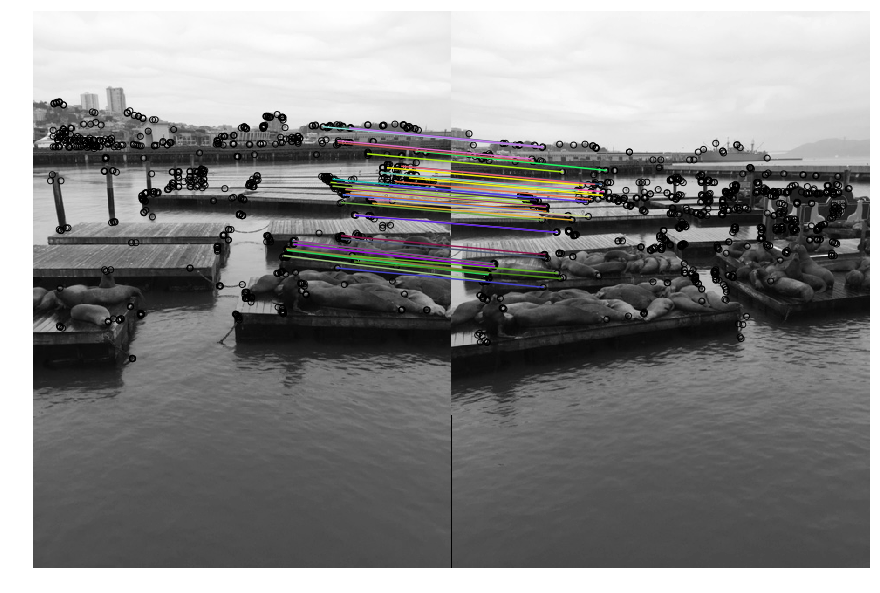

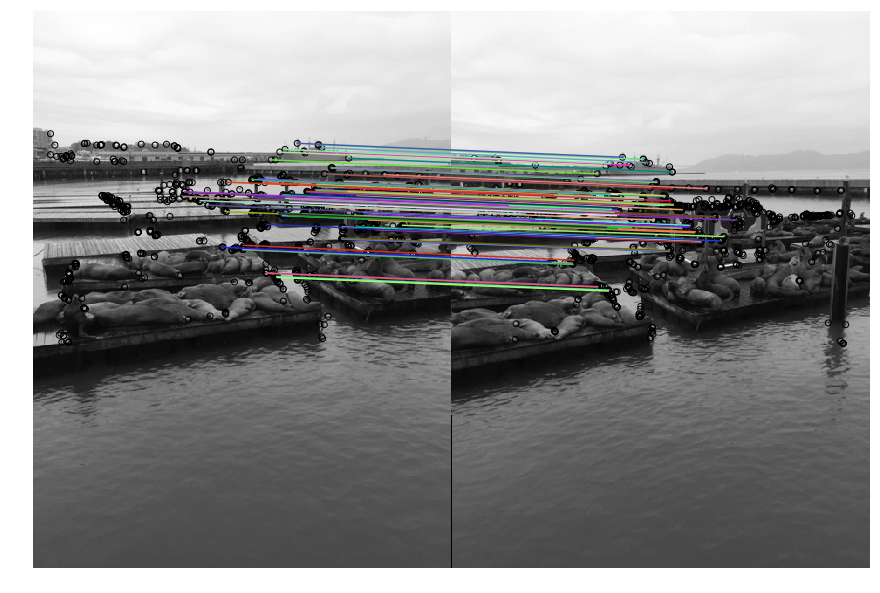

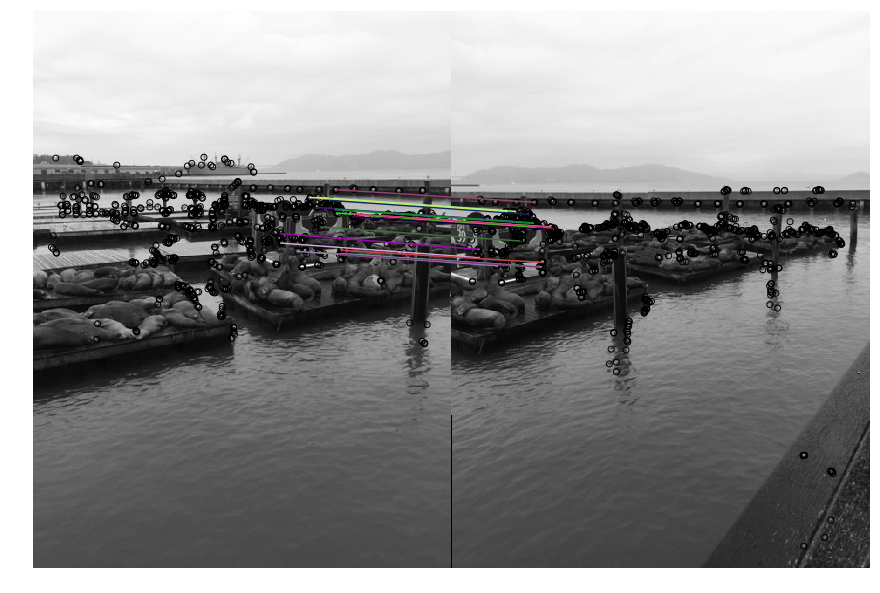

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, pano0, pano1, keypoints0, keypoints1, matches01[inliers01])

ax.axis('off');

fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano2 -> pano1
plot_matches(ax, pano1, pano2, keypoints1, keypoints2, matches12[inliers12])

ax.axis('off');

fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano2 -> pano1
plot_matches(ax, pano2, pano3, keypoints2, keypoints3, matches23[inliers23])

ax.axis('off');


Now we define the exent of our final image by warping the corners of our center (pano1) out using the warping models we found above

In [50]:

from skimage.transform import SimilarityTransform

# Shape of middle image, our registration target
r, c = pano1.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners01 = model_robust01(corners)
warped_corners12 = model_robust12(corners)
warped_corners23 = model_robust23(warped_corners12) #we must warped the already warped corners b/c the 4th image warps onto another warped image

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners01, warped_corners12, corners,warped_corners23))

# The overall output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)

Now we actually warp our images by the models we found and plot them individually to see how they look and then overlapped with eachother. We also save the masks which are boolean images that are true where the individual image is and false where the image is not

In [51]:

from skimage.transform import warp

# This in-plane offset is the only necessary transformation for the middle image
offset1 = SimilarityTransform(translation= -corner_min)

# Translate pano1 into place
pano1_warped = warp(pano1, offset1.inverse, order=3,
                    output_shape=output_shape, cval=-1)

# Acquire the image mask for later use
pano1_mask = (pano1_warped != -1)  # Mask == 1 inside image
pano1_warped[~pano1_mask] = 0      # Return background values to 0

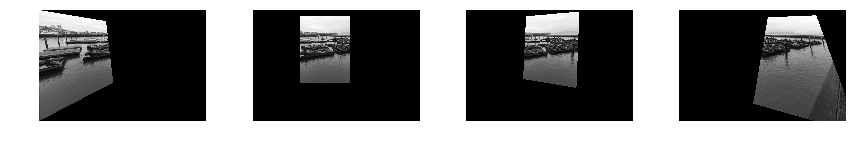

In [52]:
# Warp pano1 (2nd to left) to pano2
transform01 = (model_robust01 + offset1).inverse
pano0_warped = warp(pano0, transform01, order=3,
                    output_shape=output_shape, cval=-1)

pano0_mask = (pano0_warped != -1)  # Mask == 1 inside image
pano0_warped[~pano0_mask] = 0      # Return background values to 0

# Warp pano3 (2nd to right) to pano2 
transform12 = (model_robust12 + offset1).inverse
pano2_warped = warp(pano2, transform12, order=3,
                    output_shape=output_shape, cval=-1)

pano2_mask = (pano2_warped != -1)  # Mask == 1 inside image
pano2_warped[~pano2_mask] = 0      # Return background values to 0

# Warp pano4 (right) to pano3 
transform23 = (model_robust23 +model_robust12+ offset1).inverse  #this requires two transforms to map back to the original image
pano3_warped = warp(pano3, transform23, order=3,
                    output_shape=output_shape, cval=-1)

pano3_mask = (pano3_warped != -1)  # Mask == 1 inside image
pano3_warped[~pano3_mask] = 0      # Return background values to 0

compare(pano0_warped, pano1_warped, pano2_warped,  pano3_warped, figsize=(12, 10));

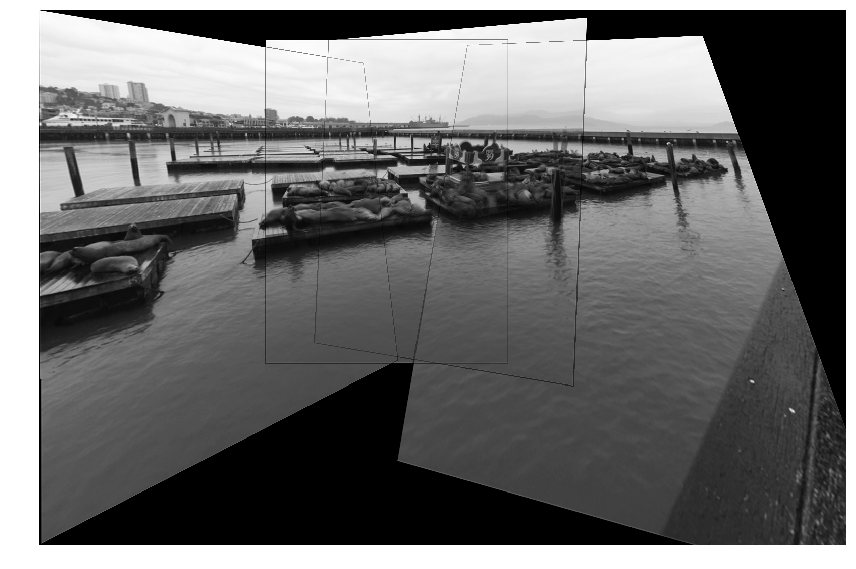

In [53]:
# Add the three images together. This could create dtype overflows!
# We know they are are floating point images after warping, so it's OK.
merged = (pano0_warped + pano1_warped + pano2_warped + pano3_warped)
# Track the overlap by adding the masks together
overlap = (pano0_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           pano1_mask + 
           pano2_mask +
           pano3_mask)
# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)

fig, ax = plt.subplots(figsize=(12, 12))

ax.imshow(normalized, cmap='gray')

plt.tight_layout()
ax.axis('off');

The above image is ok but the overlapping region between the images is poor, particularly because sea lions like to move. So what we'll do is for each overlapping area, find a continuous line through the overlapping area that is most similar in both images and to the left of that use the left image and to the right use the right image. This should help the fuzziness.

So first, define moveable starting points on the top and bottom of the image

In [54]:

ymax = output_shape[1] - 1
xmax = output_shape[0] - 1

# Start anywhere along the top and bottom, left of center.
mask_pts01 = [[0,    ymax // 4],
              [xmax, ymax // 4]]

# Start anywhere along the top and bottom, right of center.
mask_pts12 = [[0,    2*ymax // 4],
              [xmax, 2*ymax // 4]]

# Start anywhere along the top and bottom, right of center.
mask_pts23 = [[0,    3*ymax // 4],
              [xmax, 3*ymax // 4]]


In [55]:
from skimage.measure import label

def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : ndarray of floats
        Difference of two overlapping images.
    mask : ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True:
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis=0)
    lower = (labels == 2).sum(axis=0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype=np.float64)
    costs_lower = np.ones_like(lower, dtype=np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    return costs_arr

Now see what the difference in the overlapping area look like for each pair of images. It should be zero if they are identical but clearly it is not.

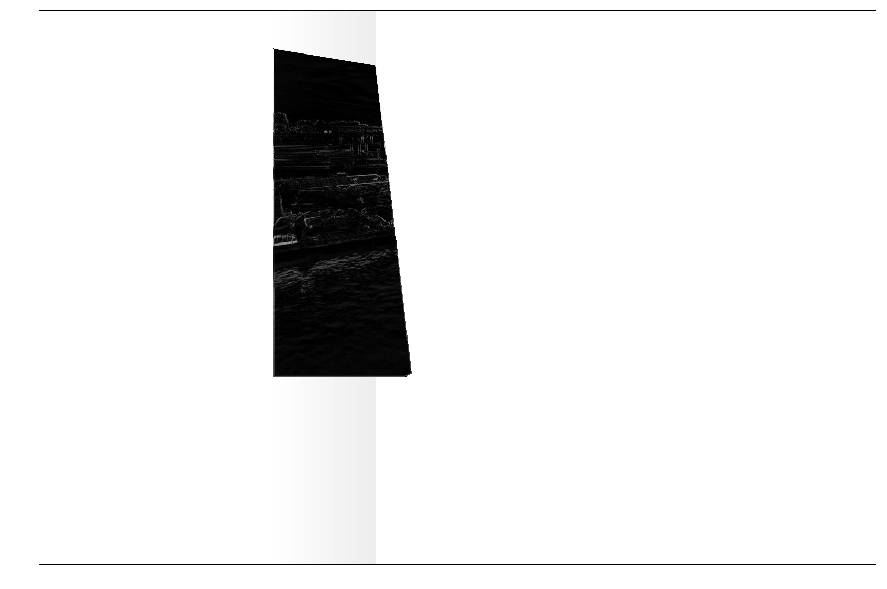

In [57]:
# Start with the absolute value of the difference image.
# np.abs is necessary because we don't want negative costs!
costs01 = generate_costs(np.abs(pano0_warped - pano1_warped),
                         pano0_mask & pano1_mask)

costs01[0,  :] = 0
costs01[-1, :] = 0

fig, ax = plt.subplots(figsize=(15, 12))

ax.imshow(costs01, cmap='gray', interpolation='none')

ax.axis('off');

Find the line through this image that is most close to 0. (This part is bad ass)

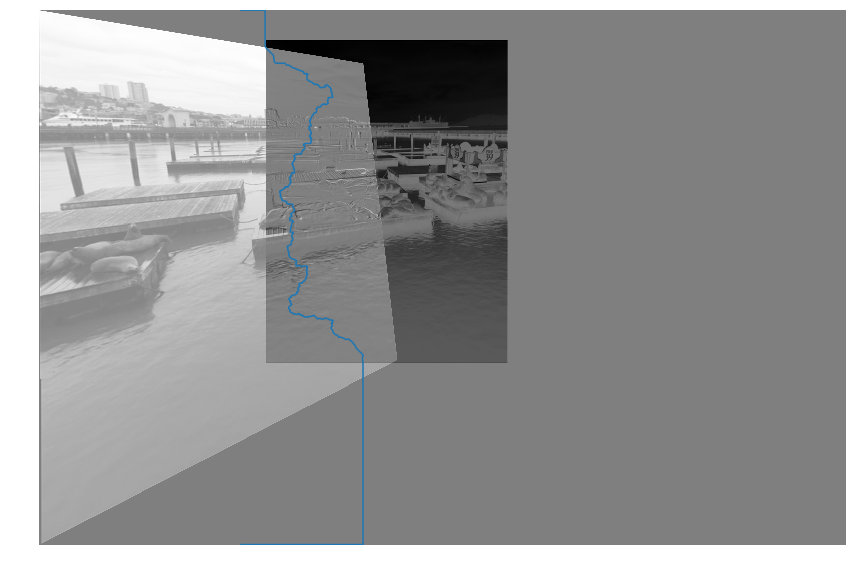

In [59]:
from skimage.graph import route_through_array

# Arguments are:
#   cost array
#   start pt
#   end pt
#   can it traverse diagonally
pts, _ = route_through_array(costs01, mask_pts01[0], mask_pts01[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

fig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(pano0_warped - pano1_warped, cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0])  

plt.tight_layout()
ax.axis('off');

Make a mask so that later we can take only the parts of tthe first warped image that are to the right of this line

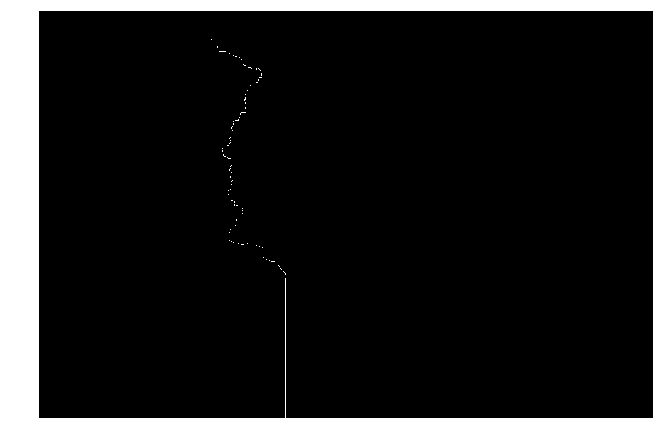

In [61]:
# Start with an array of zeros and place the path
mask0 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask0[pts[:, 0], pts[:, 1]] = 1

fig, ax = plt.subplots(figsize=(11, 11))

# View the path in black and white
ax.imshow(mask0, cmap='gray')

ax.axis('off');

Here is that mask

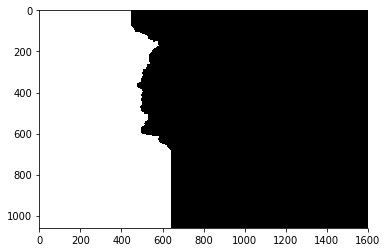

In [63]:
from skimage.measure import label

# Labeling starts with one at point (0, 0)
mask0 = (label(mask0, connectivity=1, background=-1) == 1)

# The result
plt.imshow(mask0, cmap='gray');

Repeat for each image pair

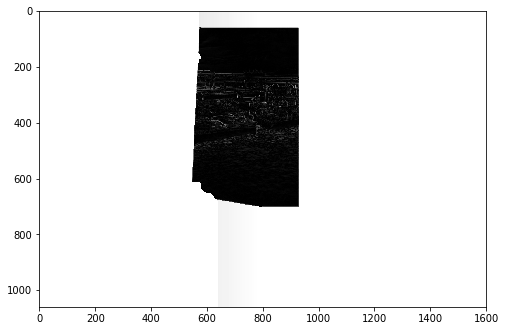

In [64]:
# Start with the absolute value of the difference image.
# np.abs necessary because we don't want negative costs!
costs12 = generate_costs(np.abs(pano1_warped - pano2_warped),
                         pano1_mask & pano2_mask)

# Allow the path to "slide" along top and bottom edges to the optimal 
# horizontal position by setting top and bottom edges to zero cost
costs12[0,  :] = 0
costs12[-1, :] = 0

costs12[mask0 > 0] = 1

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(costs12, cmap='gray');

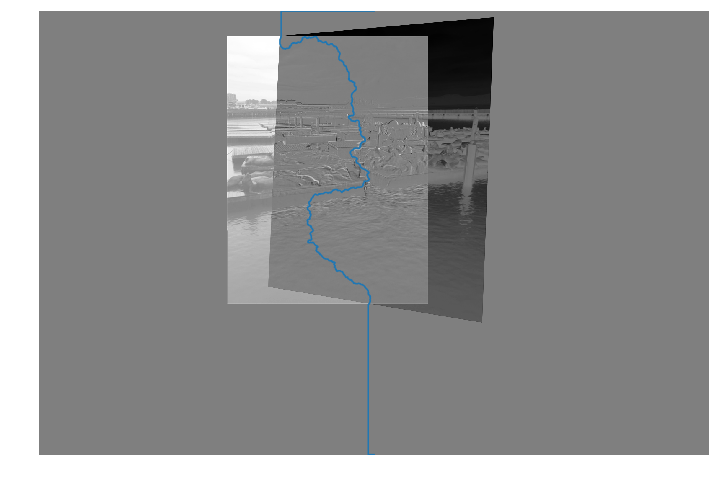

In [65]:

# Arguments are:
#   cost array
#   start pt
#   end pt
#   can it traverse diagonally
pts, _ = route_through_array(costs12, mask_pts12[0], mask_pts12[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

fig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(pano1_warped - pano2_warped, cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0]);

ax.axis('off');

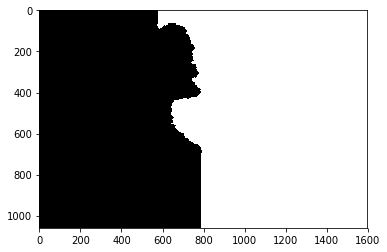

In [66]:
mask2 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask2[pts[:, 0], pts[:, 1]] = 1

mask2 = (label(mask2, connectivity=1, background=-1) == 3)

# The result
plt.imshow(mask2, cmap='gray');

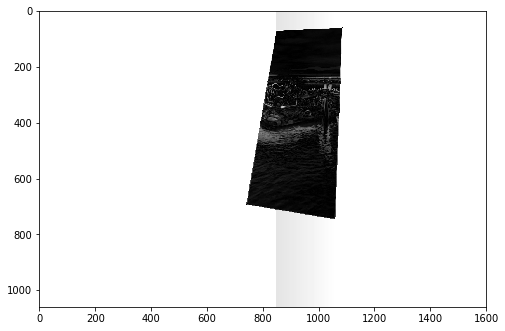

In [67]:
# Start with the absolute value of the difference image.
# np.abs necessary because we don't want negative costs!
costs23 = generate_costs(np.abs(pano2_warped - pano3_warped),
                         pano2_mask & pano3_mask)

# Allow the path to "slide" along top and bottom edges to the optimal 
# horizontal position by setting top and bottom edges to zero cost
costs23[0,  :] = 0
costs23[-1, :] = 0

costs23[mask2 < 0] = 1

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(costs23, cmap='gray');

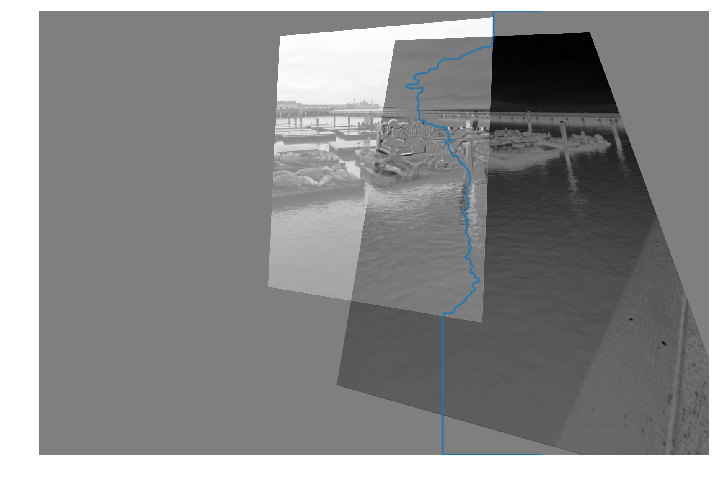

In [68]:

# Arguments are:
#   cost array
#   start pt
#   end pt
#   can it traverse diagonally
pts, _ = route_through_array(costs23, mask_pts23[0], mask_pts23[1], fully_connected=True)

# Convert list of lists to 2d coordinate array for easier indexing
pts = np.array(pts)

fig, ax = plt.subplots(figsize=(12, 12))

# Plot the difference image
ax.imshow(pano2_warped - pano3_warped, cmap='gray')

# Overlay the minimum-cost path
ax.plot(pts[:, 1], pts[:, 0]);

ax.axis('off');

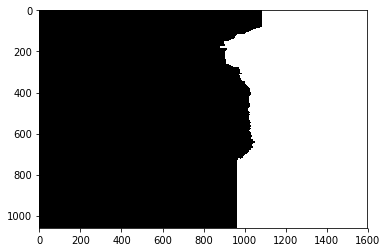

In [69]:
mask3 = np.zeros_like(pano0_warped, dtype=np.uint8)
mask3[pts[:, 0], pts[:, 1]] = 1

mask3 = (label(mask3, connectivity=1, background=-1) == 3)

# The result
plt.imshow(mask3, cmap='gray');

Now define two masks and a function to generate the slices of the images that we ultimately want

In [70]:
mask1 = ~(mask0 | mask2).astype(bool)
mask2 = ~(~mask2 | mask3).astype(bool)

def add_alpha(img, mask=None):
    """
    Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    from skimage.color import gray2rgb
    if mask is None:
        mask = np.ones_like(img)
        
    if img.ndim == 2:
        img = gray2rgb(img)
    
    return np.dstack((img, mask))

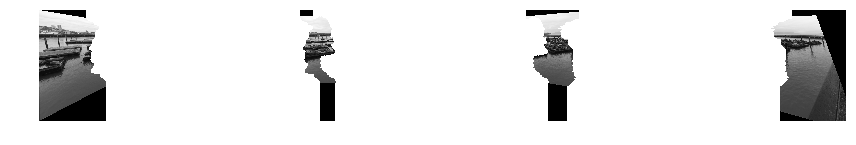

In [71]:
pano0_final = add_alpha(pano0_warped, mask0)
pano1_final = add_alpha(pano1_warped, mask1)
pano2_final = add_alpha(pano2_warped, mask2)
pano3_final = add_alpha(pano3_warped, mask3)

compare(pano0_final, pano1_final, pano2_final, pano3_final, figsize=(12, 12))

Finally display it all together!

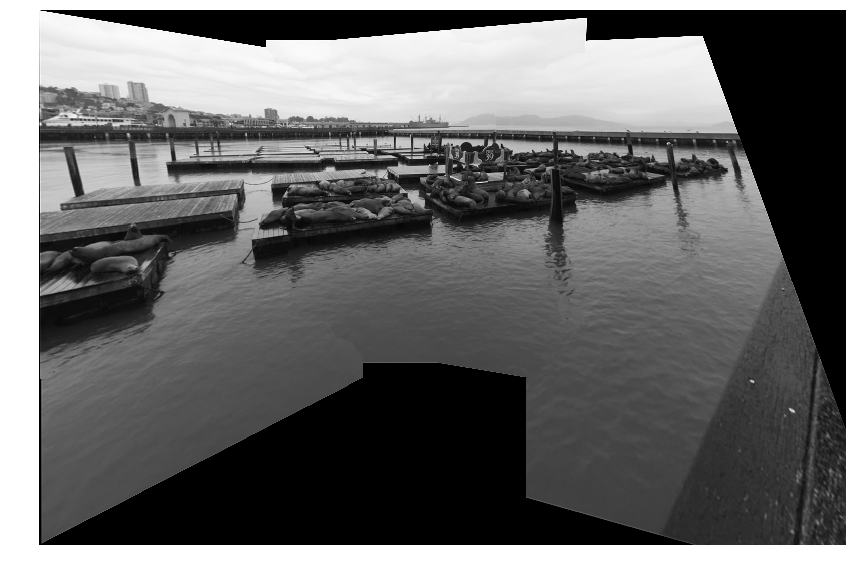

In [72]:
fig, ax = plt.subplots(figsize=(12, 12))

# This is a perfect combination, but matplotlib's interpolation
# makes it appear to have gaps. So we turn it off.
ax.imshow(pano0_final, interpolation='none')
ax.imshow(pano1_final, interpolation='none')
ax.imshow(pano2_final, interpolation='none')
ax.imshow(pano3_final, interpolation='none')

fig.tight_layout()
ax.axis('off');

On the whole this looks pretty good. Depending on the feature extraction step, the warp on the right most image (which is mapped onto another warped image can be vastly different and the far corners can be warped very far away. But the part with the sea lions almost always looks good. The stitching lines are clearly visbile in the water but that is likely becuase there was no way to cut through it with zero difference because the water moves so quickly and in such complicated patterns. I'm not really sure how you would get around this? If the image is move, I guess there isn't a lot you can do. 

## Extra: Image Stacking

Reprocess one of the datasets from http://www.rawastrodata.com/.  See http://www.rawastrodata.com/pages/typesofimages.html for a description of the different kind of images.